In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')

# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# import tensorflow.keras.layers as Layers
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.preprocessing import image
from PIL import Image

import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
import torch

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 54.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 15.8 MB/s eta 0:00:00


Here, we define a dataset class that loads images and labels for the Covid-19 X-ray classification task. We also load the pretraining chest x ray data.

class CovidData(Dataset):
Parameters:
imgs (list): A list of image paths.
labels (list): A list of image labels.
transform (torchvision.transforms.Compose): A series of data transformations to be applied to the images.

Methods:
__len__(self): Returns the length of the dataset.
__getitem__(self, idx): Returns a transformed image and its corresponding label at the given index.

In [ ]:
from datasets import load_dataset
from torchvision import transforms

# Load Pretraining Dataset

dataset = load_dataset("keremberke/chest-xray-classification", 'full')

train_x = [dataset['train'][i]['image'] for i in range(len(dataset['train']))]
train_y = [dataset['train'][i]['labels'] for i in range(len(dataset['train']))]

test_x = [dataset['test'][i]['image'] for i in range(len(dataset['test']))]
test_y = [dataset['test'][i]['labels'] for i in range(len(dataset['test']))]

from torch.utils.data import Dataset, DataLoader
import torch
from sklearn.model_selection import train_test_split
from torchvision import transforms
from sklearn.metrics import classification_report

# define transformation

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomPerspective(0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# define a simple Dataset class

class CovidData(Dataset):
    def __init__(self, imgs, labels, transform):
        super().__init__()
        self.imgs = imgs
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.transform(self.imgs[idx]), torch.tensor(self.labels[idx])
    
trainset, testset = CovidData(train_x, train_y, transform=train_transform), CovidData(test_x, test_y, transform=test_transform)
# Define dataloader
train_loader = DataLoader(trainset, batch_size=32, num_workers=4, shuffle=True)
test_loader = DataLoader(testset, batch_size=32, num_workers=4, shuffle=False)

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset chest-xray-classification downloaded and prepared to /root/.cache/huggingface/datasets/keremberke___chest-xray-classification/full/1.0.0/34d5a3d96ebfc454a409411badbd8596202f787803c69e0ba42791bbd6a12c28. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

This code block contains the train, test, classify, and accuracy calculation functions. Then, it performs pretraining and saves the best pretrain model.


In [ ]:
from tqdm import tqdm

# binary classifcation accuracy
def acc(output, target):
    output = torch.sigmoid(output) >= 0.5
    target = target == 1.0
    return (target == output).sum().item()

# training function
def train(model, opt, cri, loader, epoch):

  total_loss, total_step, total_correct, total_sample = 0.0, 0.0, 0.0, 0.0
  model.zero_grad()
  model.train()
  p_bar = tqdm(loader, total=len(loader))

  for (x,y) in p_bar:
    
    total_sample += x.size(0)
    total_step += 1
    x, y = x.cuda(), y.cuda()
    opt.zero_grad()
    pred = model(x).squeeze(-1)
    loss = cri(pred, y.float())
    loss.backward()
    opt.step()
    total_loss += loss.item()
    total_correct += acc(pred, y)

    desc = f'[Train] epoch {epoch} loss {round(total_loss/total_step, 3)} acc {round(100*total_correct/total_sample, 2)}'
    p_bar.set_description(desc)

  return round(total_loss/total_step, 3), round(100*total_correct/total_sample, 2)

# test function (without gradient update)
def test(model, cri, loader, epoch):

  total_loss, total_step, total_correct, total_sample = 0.0, 0.0, 0.0, 0.0
  model.eval()
  p_bar = tqdm(loader, total=len(loader))

  with torch.no_grad():
    for (x,y) in p_bar:
      
      total_sample += x.size(0)
      total_step += 1
      x, y = x.cuda(), y.cuda()
      pred = model(x).squeeze(-1)
      loss = cri(pred, y.float())
      total_loss += loss.item()
      total_correct += acc(pred, y)

      desc = f'[Test] epoch {epoch} loss {round(total_loss/total_step, 3)} acc {round(100*total_correct/total_sample, 2)}'
      p_bar.set_description(desc)
  return round(total_loss/total_step, 3), round(100*total_correct/total_sample, 2)

# final classification report. (with F1, recall, precision etc.)
def classify(model, loader):

  model.eval()
  p_bar = tqdm(loader, total=len(loader))
  preds, labels = [], []
  with torch.no_grad():
    for (x,y) in p_bar:
      
      x, y = x.cuda(), y.cuda()
      pred = model(x).squeeze(-1)
      pred = torch.sigmoid(pred) >= 0.5
      preds = preds + pred.tolist()
      labels = labels + y.tolist()

  print('\n', classification_report(labels, preds, target_names=['neg', 'pos']))


# load pretrained weights 
from torchvision.models import vit_b_16
from torchvision.models import ViT_B_16_Weights
model = vit_b_16(weights='IMAGENET1K_V1')
model.heads = torch.nn.Linear(768, 1)

# Pretraining

torch.cuda.empty_cache()

model = model.cuda()
opt = torch.optim.Adam(model.parameters(), lr=0.0005)
cri = torch.nn.BCEWithLogitsLoss()
EPOCH = 20

sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, EPOCH)

# logger
logs = {
    'train loss':[],
    'train acc':[],
    'test loss':[],
    'test acc':[],
    'lr':[]
    }


best_loss = 10000

for e in range(EPOCH):

  train_loss, train_acc = train(model, opt, cri, train_loader, e)
  test_loss, test_acc = test(model,  cri, test_loader, e)
  logs['train loss'].append(train_loss)
  logs['train acc'].append(train_acc)
  logs['test loss'].append(test_loss)
  logs['test acc'].append(test_acc)
  sch.step()
  logs['lr'].append(sch.get_last_lr()[0])

  # save the best model
  if test_loss <= best_loss:
    best_loss = test_loss
    torch.save(model.state_dict(), 'model.pt')


model.load_state_dict(torch.load('model.pt'))
classify(model, test_loader)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


  0%|          | 0.00/330M [00:00<?, ?B/s]

100%|██████████| 19/19 [00:07<00:00,  2.38it/s]

              precision    recall  f1-score   support

         neg       0.90      0.89      0.89       171
         pos       0.95      0.96      0.96       411

    accuracy                           0.94       582
   macro avg       0.93      0.92      0.93       582
weighted avg       0.94      0.94      0.94       582



Now we load the training set

In [ ]:
df = pd.read_csv('drive/MyDrive/data/Training_set_covid.csv')

In [ ]:
#get the path of train folder
train_img_path = 'drive/MyDrive/data/train/train' #'../input/covid19-detection/train/train'

In [ ]:
# Load image and its label

from tqdm import tqdm

imgs = []
labels = []
for i in tqdm(range(len(df['filename']))):
    img = Image.open(os.path.join(train_img_path, df['filename'][i]))
    imgs.append(img)
    labels.append(df['label'][i])

100%|██████████| 3479/3479 [48:00<00:00,  1.21it/s]


We save a loss weight to equalize the loss for positives and negatives

In [ ]:
# define loss weight w.r.t. the amount of 0 v.s. 1
loss_w = torch.tensor([406/3479, 1-406/3479])

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch
from sklearn.model_selection import train_test_split
from torchvision import transforms
from sklearn.metrics import classification_report

class CovidData(Dataset):
    def __init__(self, imgs, labels, transform):
        super().__init__()
        self.imgs = imgs
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.transform(self.imgs[idx]), torch.tensor(self.labels[idx])

We add transforms to the training and test sets as well as normalization.

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomPerspective(0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
    
train_x, test_x, train_y, test_y = train_test_split(imgs, labels, test_size=0.2, random_state=1234)
trainset, testset = CovidData(train_x, train_y, transform=train_transform), CovidData(test_x, test_y, transform=test_transform)

train_loader = DataLoader(trainset, batch_size=32, shuffle=True)
test_loader = DataLoader(testset, batch_size=32, shuffle=False)

Now, we train the model on the actual training data. We do not use weighted loss here. We save the best model and log loss.

In [ ]:
# Normal Training

# load the previously trained weight
model.load_state_dict(torch.load('model.pt'))
# new prediction head
model.heads = torch.nn.Linear(768, 1)

torch.cuda.empty_cache()

model = model.cuda()
opt = torch.optim.Adam(model.parameters(), lr=0.0005)
cri = torch.nn.BCEWithLogitsLoss()
EPOCH = 10

sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, EPOCH)

logs = {
    'train loss':[],
    'train acc':[],
    'test loss':[],
    'test acc':[],
    'lr':[]
    }


best_loss = 10000

for e in range(EPOCH):

  train_loss, train_acc = train(model, opt, cri, train_loader, e)
  test_loss, test_acc = test(model,  cri, test_loader, e)
  logs['train loss'].append(train_loss)
  logs['train acc'].append(train_acc)
  logs['test loss'].append(test_loss)
  logs['test acc'].append(test_acc)
  sch.step()
  logs['lr'].append(sch.get_last_lr()[0])
  if test_loss <= best_loss:
    best_loss = test_loss
    torch.save(model.state_dict(), 'model2.pt')


model.load_state_dict(torch.load('model2.pt'))
classify(model, test_loader)

100%|██████████| 22/22 [00:10<00:00,  2.15it/s]

              precision    recall  f1-score   support

         neg       0.99      0.96      0.97       613
         pos       0.74      0.92      0.82        83

    accuracy                           0.95       696
   macro avg       0.86      0.94      0.89       696
weighted avg       0.96      0.95      0.95       696



This code generates three plots: one showing the training and testing loss for each epoch, another showing the training and testing accuracy for each epoch, and the last one showing the learning rate for each epoch. The data for the plots comes from the logs dictionary which stores the training and testing loss, accuracy and learning rate for each epoch. 

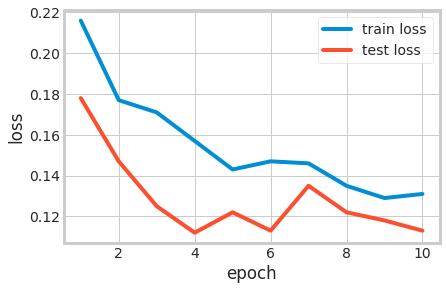

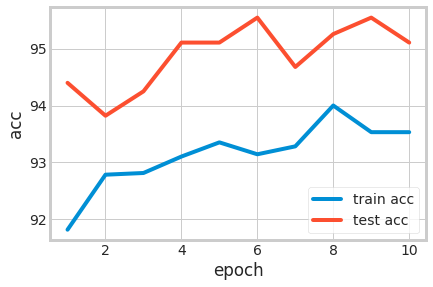

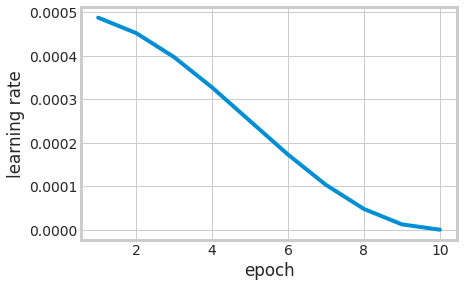

In [ ]:
import matplotlib.pyplot as plt

x = [i for i in range(1, 11)]

# loss
plt.plot( x, logs['train loss'], label='train loss')
plt.plot( x, logs['test loss'], label='test loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

plt.clf()

# acc
plt.plot( x, logs['train acc'], label='train acc')
plt.plot( x, logs['test acc'], label='test acc')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend()
plt.show()

plt.clf()

# lr

plt.plot( x, logs['lr'], label='learning rate')
plt.xlabel('epoch')
plt.ylabel('learning rate')
plt.show()

Now, we train with the weighted equalized loss.

In [ ]:
# Weighted Loss Training

model = vit_b_16(weights='IMAGENET1K_V1')
model.heads = torch.nn.Linear(768, 1)
model.load_state_dict(torch.load('./model.pt'))

torch.cuda.empty_cache()

model = model.cuda()
opt = torch.optim.Adam(model.parameters(), lr=0.0005)
# weighted BCE Loss here.
loss_w = torch.tensor([1-406/3479]).cuda()
cri = torch.nn.BCEWithLogitsLoss(weight=loss_w)
EPOCH = 10

sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, EPOCH)

logs = {
    'train loss':[],
    'train acc':[],
    'test loss':[],
    'test acc':[],
    'lr':[]
    }


best_loss = 10000

for e in range(EPOCH):

  train_loss, train_acc = train(model, opt, cri, train_loader, e)
  test_loss, test_acc = test(model,  cri, test_loader, e)
  logs['train loss'].append(train_loss)
  logs['train acc'].append(train_acc)
  logs['test loss'].append(test_loss)
  logs['test acc'].append(test_acc)
  sch.step()
  logs['lr'].append(sch.get_last_lr()[0])
  if test_loss <= best_loss:
    best_loss = test_loss
    torch.save(model.state_dict(), 'model.pt')


model.load_state_dict(torch.load('model.pt'))
classify(model, test_loader)

100%|██████████| 22/22 [00:10<00:00,  2.14it/s]

              precision    recall  f1-score   support

         neg       0.98      0.96      0.97       613
         pos       0.75      0.88      0.81        83

    accuracy                           0.95       696
   macro avg       0.87      0.92      0.89       696
weighted avg       0.96      0.95      0.95       696



This code generates three plots: one showing the training and testing loss for each epoch, another showing the training and testing accuracy for each epoch, and the last one showing the learning rate for each epoch. The data for the plots comes from the logs dictionary which stores the training and testing loss, accuracy and learning rate for each epoch. 

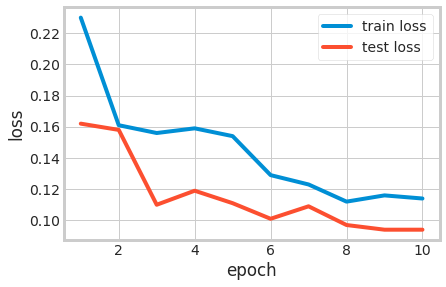

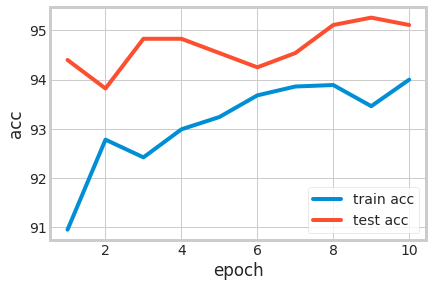

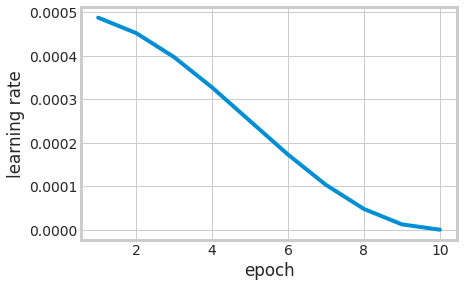

In [ ]:
import matplotlib.pyplot as plt

x = [i for i in range(1, 11)]

# loss
plt.plot( x, logs['train loss'], label='train loss')
plt.plot( x, logs['test loss'], label='test loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

plt.clf()

# acc
plt.plot( x, logs['train acc'], label='train acc')
plt.plot( x, logs['test acc'], label='test acc')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend()
plt.show()

plt.clf()

# lr

plt.plot( x, logs['lr'], label='learning rate')
plt.xlabel('epoch')
plt.ylabel('learning rate')
plt.show()